In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/VietAI/FoDL2/RNN/torch_tutorial")



# NLP From Scratch: Generating Names with a Character-Level RNN
**Author**: [Sean Robertson](https://github.com/spro)

This is our second of three tutorials on "NLP From Scratch".
In the [first tutorial](/intermediate/char_rnn_classification_tutorial)
we used a RNN to classify names into their language of origin. This time
we'll turn around and generate names from languages.

::

    > python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    > python sample.py German GER
    Gerren
    Ereng
    Rosher

    > python sample.py Spanish SPA
    Salla
    Parer
    Allan

    > python sample.py Chinese CHI
    Chan
    Hang
    Iun

We are still hand-crafting a small RNN with a few linear layers. The big
difference is instead of predicting a category after reading in all the
letters of a name, we input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be
done with words or other higher order constructs) is often referred to
as a "language model".

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  [The Unreasonable Effectiveness of Recurrent Neural
   Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)_
   shows a bunch of real life examples
-  [Understanding LSTM
   Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)_
   is about LSTMs specifically but also informative about RNNs in
   general

I also suggest the previous tutorial, :doc:`/intermediate/char_rnn_classification_tutorial`


## Preparing the Data

.. Note::
   Download the data from
   [here](https://download.pytorch.org/tutorial/data.zip)
   and extract it to the current directory.

See the last tutorial for more detail of this process. In short, there
are a bunch of plain text files ``data/names/[Language].txt`` with a
name per line. We split lines into an array, convert Unicode to ASCII,
and end up with a dictionary ``{language: [names ...]}``.


In [5]:
# Import necessary libraries
from io import open
import glob
import os
import unicodedata
import string

# Define a set of all valid characters, including letters, punctuation, and some special characters
all_letters = string.ascii_letters + " .,;'-"
# Add one to account for the end-of-sentence marker (EOS)
n_letters = len(all_letters) + 1 # Plus EOS marker

# Define a function to find files in a given path using glob
def findFiles(path): return glob.glob(path)

# Function to convert a Unicode string to plain ASCII by removing diacritics and filtering for valid characters
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'  # Mn: Non-spacing Mark
        and c in all_letters
    )

# Function to read lines from a file and convert them to ASCII format
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Initialize an empty dictionary to hold lines for each category
category_lines = {}
# Initialize an empty list to store all unique category names
all_categories = []

# Loop through all text files in the 'data/names/' directory
for filename in findFiles('data/names/*.txt'):
    # Extract the category name from the file name by removing the extension
    category = os.path.splitext(os.path.basename(filename))[0]
    # Add the category name to the list of all categories
    all_categories.append(category)
    # Read and convert the lines from the file to ASCII format
    lines = readLines(filename)
    # Store the converted lines in the category_lines dictionary
    category_lines[category] = lines

# Calculate the total number of categories
n_categories = len(all_categories)

# Check if no data was found and raise an error if so
if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

# Print the number of categories and the list of all categories
print('# categories:', n_categories, all_categories)

# Test the unicodeToAscii function by converting a sample name
print(unicodeToAscii("O'Néàl"))


# categories: 18 ['German', 'Czech', 'Korean', 'English', 'Arabic', 'Spanish', 'Irish', 'Dutch', 'Scottish', 'Italian', 'Portuguese', 'Chinese', 'Russian', 'Polish', 'French', 'Greek', 'Japanese', 'Vietnamese']
O'Neal


## Creating the Network

This network extends [the last tutorial's RNN](#Creating-the-Network)_
with an extra argument for the category tensor, which is concatenated
along with the others. The category tensor is a one-hot vector just like
the letter input.

We will interpret the output as the probability of the next letter. When
sampling, the most likely output letter is used as the next input
letter.

I added a second linear layer ``o2o`` (after combining hidden and
output) to give it more muscle to work with. There's also a dropout
layer, which [randomly zeros parts of its
input](https://arxiv.org/abs/1207.0580)_ with a given probability
(here 0.1) and is usually used to fuzz inputs to prevent overfitting.
Here we're using it towards the end of the network to purposely add some
chaos and increase sampling variety.

.. figure:: https://i.imgur.com/jzVrf7f.png
   :alt:





This code defines a recurrent neural network (RNN) class. Here's a breakdown of its components:

1. `RNN` class:
   - This class inherits from `nn.Module`, the base class for all PyTorch models.
   - The constructor `__init__` initializes the RNN with the specified `input_size`, `hidden_size`, and `output_size`.
   - It defines several layers:
     - `self.i2h`: Linear transformation layer for input to hidden connections.
     - `self.i2o`: Linear transformation layer for input to output connections.
     - `self.o2o`: Linear transformation layer for hidden to output connections.
     - `self.dropout`: Dropout layer with a dropout rate of 0.1 to prevent overfitting.
     - `self.softmax`: Log-softmax activation function applied to the output.

2. `forward` method:
   - This method defines the forward pass of the RNN.
   - It takes `category`, `input`, and `hidden` tensors as inputs and computes the output and the new hidden state.
   - It concatenates the input tensors along the specified dimensions.
   - It computes the new hidden state and output scores using the linear layers.
   - It concatenates the hidden state and output scores, applies a linear transformation to get the final output, applies dropout, and computes softmax probabilities.

3. `initHidden` method:
   - This method initializes the hidden state with zeros when the RNN is first used.

Overall, this code defines the architecture and forward pass of an RNN model for a specific task. It's designed to take input tensors, update the hidden state, and produce output probabilities.

In [12]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        # Define linear transformation layers for input to hidden and input to output connections
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)

        # Define a linear transformation layer for hidden to output connection
        self.o2o = nn.Linear(hidden_size + output_size, output_size)

        # Define a dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.1)

        # Define a softmax activation function to compute probabilities over output categories
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        # Concatenate the category, input, and hidden state into one tensor
        input_combined = torch.cat((category, input, hidden), 1)

        # Compute the new hidden state
        hidden = self.i2h(input_combined)

        # Compute the output scores
        output = self.i2o(input_combined)

        # Combine the hidden state and output scores
        output_combined = torch.cat((hidden, output), 1)

        # Apply a linear transformation from hidden to output
        output = self.o2o(output_combined)

        # Apply dropout to the output to prevent overfitting
        output = self.dropout(output)

        # Apply the softmax activation function to get output probabilities
        output = self.softmax(output)

        return output, hidden

    def initHidden(self):
        # Initialize the hidden state with zeros
        return torch.zeros(1, self.hidden_size)


## Training
Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):




In [13]:
import random

# Function to choose a random item from a list
def randomChoice(l):
    # Generate a random index within the range of the list
    random_index = random.randint(0, len(l) - 1)
    # Return the item at the randomly selected index
    return l[random_index]

# Function to obtain a random category and a random line from that category
def randomTrainingPair():
    # Choose a random category from the list of all categories
    category = randomChoice(all_categories)
    # Choose a random line (name) from the selected category's list of lines
    line = randomChoice(category_lines[category])
    # Return the randomly selected category and line
    return category, line


For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

.. figure:: https://i.imgur.com/JH58tXY.png
   :alt:

The category tensor is a [one-hot
tensor](https://en.wikipedia.org/wiki/One-hot)_ of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.




In [14]:
# Function to create a one-hot vector for a given category
def categoryTensor(category):
    # Find the index of the category in the list of all categories
    li = all_categories.index(category)
    # Create a tensor filled with zeros, with a shape of (1, n_categories)
    tensor = torch.zeros(1, n_categories)
    # Set the element at the found index to 1 to represent the category as a one-hot vector
    tensor[0][li] = 1
    return tensor

# Function to create a one-hot matrix for the input line (sequence of characters)
def inputTensor(line):
    # Create a tensor filled with zeros, with a shape of (len(line), 1, n_letters)
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        # Find the index of the letter in the list of all valid letters (all_letters)
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# Function to create a tensor representing the target (output) sequence as a sequence of indices
def targetTensor(line):
    # Create a list of letter indices for the characters in the line (excluding the last character, EOS)
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    # Append the index of the EOS character to indicate the end of the sequence
    letter_indexes.append(n_letters - 1)  # EOS
    # Convert the list of indices to a PyTorch LongTensor
    return torch.LongTensor(letter_indexes)


For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




In [15]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    # Generate a random category and corresponding line
    category, line = randomTrainingPair()

    # Convert the category and line into tensors
    category_tensor = categoryTensor(category)        # Convert category to tensor
    input_line_tensor = inputTensor(line)              # Convert input line to tensor
    target_line_tensor = targetTensor(line)            # Convert target line to tensor

    # Return the category tensor, input line tensor, and target line tensor as training data
    return category_tensor, input_line_tensor, target_line_tensor


### Training the Network

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




In [16]:
# Define the loss function for training, which is the Negative Log-Likelihood Loss
criterion = nn.NLLLoss()

# Set the learning rate for the training process
learning_rate = 0.0005

# Define the training function that takes category, input line, and target line tensors as inputs
def train(category_tensor, input_line_tensor, target_line_tensor):
    # Add an extra dimension to the target line tensor to match the output shape
    target_line_tensor.unsqueeze_(-1)

    # Initialize the hidden state for the RNN
    hidden = rnn.initHidden()

    # Zero the gradients in the RNN model
    rnn.zero_grad()

    # Initialize the loss as a Tensor with a value of 0
    loss = torch.Tensor([0])

    # Loop through each character in the input line tensor
    for i in range(input_line_tensor.size(0)):
        # Pass the category, input character, and current hidden state through the RNN
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)

        # Calculate the loss for the current character in the target line
        l = criterion(output, target_line_tensor[i])

        # Accumulate the loss for the entire input line
        loss += l

    # Backpropagate the gradients
    loss.backward()

    # Update the model's parameters using gradient descent
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    # Calculate and return the output and average loss per character
    return output, loss.item() / input_line_tensor.size(0)


To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




In [17]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every ``print_every``
examples, and keeping store of an average loss per ``plot_every`` examples
in ``all_losses`` for plotting later.




In [18]:
# Initialize the RNN model with input size, hidden size, and output size
rnn = RNN(n_letters, 128, n_letters)

# Set the total number of training iterations
n_iters = 100000

# Define when to print and plot the training progress
print_every = 5000  # Print the loss every 5000 iterations
plot_every = 500    # Store average loss for plotting every 500 iterations

# Initialize a list to store all the losses for plotting
all_losses = []

# Initialize a variable to keep track of the total loss within each "plot_every" iterations
total_loss = 0

# Start measuring the time for training
start = time.time()

# Loop through the specified number of training iterations
for iter in range(1, n_iters + 1):
    # Train the model with a random training example, and get the output and loss
    output, loss = train(*randomTrainingExample())

    # Accumulate the loss for the current iteration
    total_loss += loss

    # Print the current training progress at specified intervals
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    # Store the average loss for plotting at specified intervals
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0


0m 22s (5000 5%) 3.1747
0m 36s (10000 10%) 3.1874
0m 51s (15000 15%) 2.7305
1m 6s (20000 20%) 3.0836
1m 20s (25000 25%) 3.0038
1m 35s (30000 30%) 2.1956
1m 50s (35000 35%) 2.4639
2m 5s (40000 40%) 1.8922
2m 19s (45000 45%) 3.4751
2m 34s (50000 50%) 2.7231
2m 48s (55000 55%) 1.8002
3m 2s (60000 60%) 2.2832
3m 16s (65000 65%) 2.9340
3m 30s (70000 70%) 2.2832
3m 45s (75000 75%) 2.6262
3m 59s (80000 80%) 1.9527
4m 13s (85000 85%) 2.5445
4m 27s (90000 90%) 2.6145
4m 41s (95000 95%) 2.3089
4m 56s (100000 100%) 2.5663


### Plotting the Losses

Plotting the historical loss from all\_losses shows the network
learning:




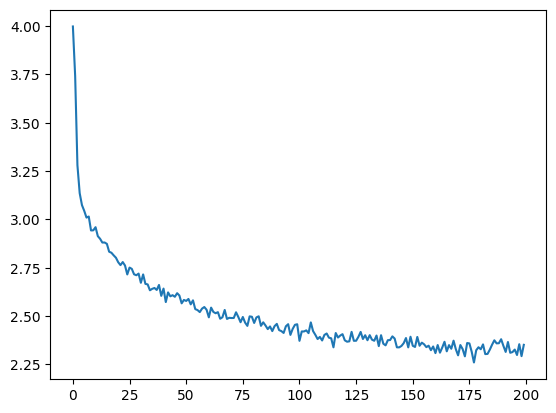

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

## Sampling the Network

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-  Create tensors for input category, starting letter, and empty hidden
   state
-  Create a string ``output_name`` with the starting letter
-  Up to a maximum output length,

   -  Feed the current letter to the network
   -  Get the next letter from highest output, and next hidden state
   -  If the letter is EOS, stop here
   -  If a regular letter, add to ``output_name`` and continue

-  Return the final name

.. Note::
   Rather than having to give it a starting letter, another
   strategy would have been to include a "start of string" token in
   training and have the network choose its own starting letter.




In [20]:
# Define the maximum length for generated samples
max_length = 20

# Function to sample a name from a given category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # Disable gradient tracking during sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        # Generate a name character by character
        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Function to generate multiple samples for a category and starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        # Generate and print a sample name for the given category and starting letter
        print(sample(category, start_letter))

# Generate and print samples for different categories and starting letters
samples('Russian', 'RUS')   # Generate Russian names starting with 'R', 'U', and 'S'
samples('German', 'GER')    # Generate German names starting with 'G', 'E', and 'R'
samples('Spanish', 'SPA')   # Generate Spanish names starting with 'S', 'P', and 'A'
samples('Chinese', 'CHI')   # Generate Chinese names starting with 'C', 'H', and 'I'


Rovarov
Uarakovak
Santovov
Garter
Erang
Roure
Saran
Parra
Arara
Chan
Hang
Iun


## Exercises

-  Try with a different dataset of category -> line, for example:

   -  Fictional series -> Character name
   -  Part of speech -> Word
   -  Country -> City

-  Use a "start of sentence" token so that sampling can be done without
   choosing a start letter
-  Get better results with a bigger and/or better shaped network

   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network


